# Biodiversity Assesment of the Phoenix Metropolitan Area

A geographic assesment of biodiversity in Maricopa County, utilizing the biodiversity intactness index (BII).

## Background
Add summary...

## Project Setup

### Import Libraries

In [43]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray as rioxr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches 

from shapely.geometry import Polygon
from rasterio.features import rasterize # for rasterizing polygons

from pystac_client import Client
import planetary_computer

import os
import contextily as cx

### Loading Data
BII will be accessed through the MPC STAC catalog, search for `io-biodiversity`

In [2]:
# access mpc catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,)

# store bounding box
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

# search for bii data for area of interest
search = catalog.search(
    collections = ['io-biodiversity'],
    bbox = bbox,
    datetime = '2017/2020')

# retrieve items from search
items = search.item_collection()

# store items for years of interest
item_2020 = items[0]
item_2017 = items[3]

In [3]:
# print item assets for easy access
for key in item_2017.assets.keys():
    print(key, '--', item_2017.assets[key].title)

data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


Information on Phoenix subdivisions will be created using US Census data:

In [4]:
az = gpd.read_file(os.path.join('data','tl_2022_04_cousub.shp'))
phx = az[az.NAME == 'Phoenix']

## Area of Interest
Before analyzing changes in biodiversity, it it is useful to visualize the area of interest. The following code produces a map of Arizona, highlighting the Phoenix Subdivision that we are interested in.

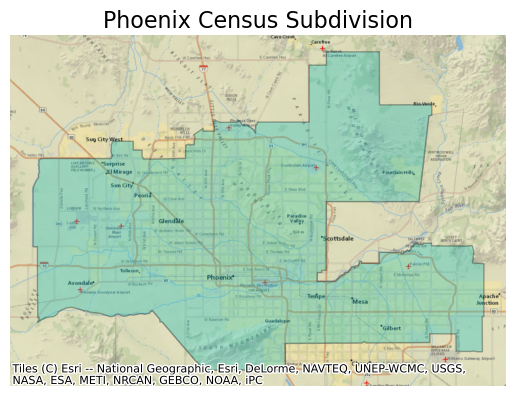

In [5]:
fig, ax = plt.subplots() #create figure

phx.to_crs(epsg=3857).plot(ax=ax, figsize = (12,8), alpha = 0.3, #plot phoenix
                          edgecolor='k', color='c')

cx.add_basemap(ax, source=cx.providers.Esri.NatGeoWorldMap) # add basemap

# update axes
ax.set_title("Phoenix Census Subdivision", fontdict={"fontsize": "16"})
ax.set_axis_off()

## Assessing Biodiversity Loss
Biodiversity loss in the Phoenix Subdivision will be assessed using data on the biodiversity intactness index (BII). This analysis examines areas where the BII is at least 75% and compares the changes in these areas from 2017 to 2020.

### Percentage of Area
The first analysis is an estimate of the percentage of area within the Phoenix subdivision that have a BII of at least 0.75

__Percetange of Area in 2017:__

In [6]:
# pull bii data as xarray, set greater than 0.75
bii_2017 = rioxr.open_rasterio(item_2017.assets['data'].href) >= 0.75 

# squeeze and drop extra band
bii_2017 = bii_2017.squeeze().drop('band')

# concert T/F to 0/1
bii_2017 = bii_2017.astype(int)

# calculate and store pixels per class
pixel, count = np.unique(bii_2017, return_counts=True)

# create df w/pixel count information
df_2017 = {'value': pixel,
          'count': count}
df_2017 = pd.DataFrame(df_2017)

# calculate percent of area 
df_2017['pct_area'] = ((df_2017['count']/
                       df_2017['count'].sum())*100)
df_2017

,value,count,pct_area
0,0,12795850,20.033563
1,1,51076214,79.966437


__Percentage of Area in 2020:__

In [7]:
# repeat workflow for 2020 bii
bii_2020 = rioxr.open_rasterio(item_2020.assets['data'].href) >= 0.75 # select and import data

bii_2020 = bii_2020.squeeze().drop('band') #drop extra band and coords

bii_2020 = bii_2020.astype(int) # convert to integer

pixel1, count1 = np.unique(bii_2020, return_counts=True) #calculate individual pixel counts

df_2020 = {'value': pixel1, 
          'count': count1}
df_2020 = pd.DataFrame(df_2020) # create df of values

df_2020['pct_area'] = ((df_2020['count']/ 
                       df_2020['count'].sum())*100) #calculate percent area
df_2020

,value,count,pct_area
0,0,12892116,20.18428
1,1,50979948,79.81572


__Interpretation:__

The `value` column indicates whether or not the BII is over 75%, where a value of 1 indicates a high BII. The `count` column is the number of individual pixels within the `xarray.DataArray`. 

Based on the percentages calculated above, the percent of area in the Phoenix Subdivision with a BII greater than or equal to 75% in 2017 was 79.96%. This is only slightly higher than the 2020 area of 79.81%, indicating minimal changes in BII between 2017 and 2020.

### Mapping out BII Changes

Cropping BII data to Phoenix subdivision:

In [8]:
# crop 2020 BII data to Phoenix Subdivision
bii_2020_raw = rioxr.open_rasterio(item_2020.assets['data'].href).squeeze().drop('band')

# check if BII and phx crs match
print(f'BII CRS: {bii_2020_raw.rio.crs}\n Phoenix CRS: {phx.crs}')

# transform Phoenix
phx = phx.to_crs(bii_2020_raw.rio.crs)

BII CRS: EPSG:4326
 Phoenix CRS: EPSG:4269


In [9]:
# create mask of Phoenix subdivision
mask = rasterize(shapes = [phx.loc[10,'geometry']],
                out_shape = bii_2020_raw.shape,
                transform = bii_2020_raw.rio.transform(),
                all_touched = True)

# apply mask over 2020 BII raster and clip
bii_phx_2020 = bii_2020_raw * mask
bii_phx_2020 = bii_phx_2020.rio.clip([phx.loc[10,'geometry']])

Find areas that fell under 0.75 BII from 2017 to 2020:

In [22]:
# Find the difference in BII between 2017 and 2020
bii_diff = bii_2017 - bii_2020

# select values of 1 (where BII dropped below 0.75 from 2017 to 2020)
bii_diff = bii_diff.where(bii_diff == 1.0)

# crop diff raster to Phoenix
bii = bii_diff * mask
bii = bii.rio.clip([phx.loc[10,'geometry']])

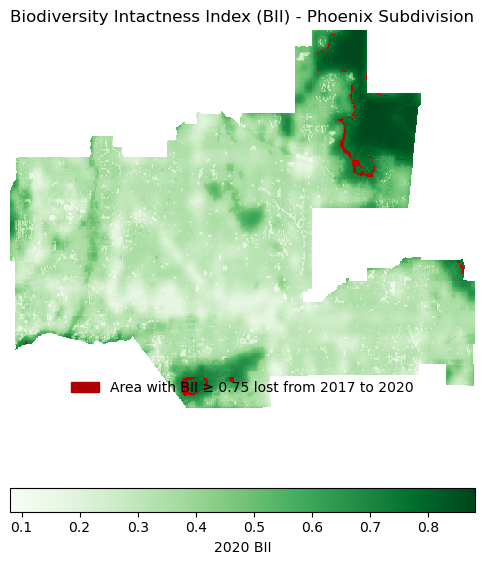

In [57]:
# create empty figure
fig, ax = plt.subplots(figsize = (6,7))

# remove axis
ax.axis('off')

# plot BII from 2020
bii_phx_2020.plot(ax=ax, cmap = 'Greens',
                  cbar_kwargs={"location": "bottom",
                               'label': "2020 BII"})


# plot BII difference areas
bii.plot(ax=ax, cmap='gist_heat', add_colorbar = False)
patch = mpatches.Patch(color = '#B00005',
                      label = 'Area with BII ≥ 0.75 lost from 2017 to 2020')
# add title
ax.set_title('Biodiversity Intactness Index (BII) - Phoenix Subdivision')

ax.legend(handles = [patch], loc='lower center', frameon=False)